# Weather and Electricity Data Analysis Notebook


### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns



### Data formating

In [2]:

def format_climate(file_path):
    df = pd.read_csv(file_path)
    
    df.replace('-', pd.NA, inplace=True)
    #df.dropna(inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    df = df.drop(columns='Station')

    df['Total Rainfall Mm'] = pd.to_numeric(df['Total Rainfall Mm'], errors='coerce')
    df['Mean Air Temperature in Celsius'] = pd.to_numeric(df['Mean Air Temperature in Celsius'], errors='coerce')
    df['Mean Vapour Pressure Hpa'] = pd.to_numeric(df['Mean Vapour Pressure Hpa'], errors='coerce')
    df['Mean Wind Speed M/Sec'] = pd.to_numeric(df['Mean Wind Speed M/Sec'], errors='coerce')
    df['Days Of Wind Gust >= 24 Knots in Day'] = pd.to_numeric(df['Days Of Wind Gust >= 24 Knots in Day'], errors='coerce')
    df['Standard Deviation Of Daily Mean Temperature in Celsius'] = pd.to_numeric(df['Standard Deviation Of Daily Mean Temperature in Celsius'], errors='coerce')
    df_grouped = df.groupby('Date').mean().reset_index()

    return df_grouped

In [3]:
def format_eletricity_data(file_path, business = False):
    df = pd.read_csv(file_path)
    
    df['Period start'] = pd.to_datetime(df['Period start'], format='%d/%m/%y')
    #df.dropna(inplace=True)
    #df.reset_index(drop=True, inplace=True)


    if business:
        df = df.drop(columns=[
            'Regional demand (GWh)',
            'Proportion of regional demand (%)', 
            'National demand (GWh)',
            'Proportion of national demand (%)'])
        return df
    
    df = df.drop(columns=[
        'Est. Total demand (GWh)',
        'Est. proportion of regional demand',
        'Est. proportion of national demand', 'Average consumption (kWh)',
        'Average daily consumption (kWh)', '5th percentile (kWh)',
        '25th percentile (kWh)', '50th percentile (kWh)',
        '75th percentile (kWh)', '95th percentile (kWh)', 'Coverage %'])

    return df
    

In [4]:
def read_climate_list(file_list, file_path):
    data_list = []
    zone_names = ['UNI', 'LSI', 'USI', 'LNI', 'CNI']

    for i in file_list:
        data_list.append(format_climate(file_path+ i))
    
    for i in range(len(data_list)):
        data_list[i]['Region ID'] = zone_names[i]
        
    return data_list

In [5]:
def read_electricity_list(file_list, file_path):
    data_list = []
    data_list.append(format_eletricity_data(file_path+file_list[0], True))
    data_list.append(format_eletricity_data(file_path+file_list[1]))
    return data_list

In [6]:
def merge_data(climate_data, electricity_data):
    data = pd.merge(climate_data, electricity_data, on=['Date', 'Region ID'])
    data.drop(columns=[ 'Period end', 'Region ID', 'Region description', 'Region'], inplace=True)
        
    return data


### Read data files using helper functions above

In [7]:
ClimateDatafilelist = ['NewUpperNorthRegions.csv', 'NewLowerSouthRegions.csv', 'NewUpperSouthARegions.csv','NewLowerNorthRegions.csv', 'NewCentralNorthRegions.csv']
ClimatePath = '../ClimateDataProcessing/'
ElectricityDatafilelist = ['Business_demand_trends_20240901140306.csv', 'Residential_consumption_trends_20240901141207.csv']
ElectricityPath = '../ElectricityData/'

climate_data = read_climate_list(ClimateDatafilelist, ClimatePath)
electricity_data = read_electricity_list(ElectricityDatafilelist, ElectricityPath)

Make the missing value identified in Weather Preprocessing notebook the value of previous valid value

In [8]:
#Remove months that are not recorded (because of future monts)
unobserved_rows = [175, 176, 177, 178, 179]
for i in range(len(climate_data)):
    climate_data[i].drop(unobserved_rows, inplace=True)

#Fill missing wind speed days with previous valid value
climate_data[0].ffill(inplace=True)

### Sanity Checks

In [9]:
electricity_period_matches = electricity_data[1]['Period start'].isin(electricity_data[0]['Period start'].values) # Check if the periods match
electricity_data[1][~electricity_period_matches] # Show the periods that don't match

,Period start,Period end,Region ID,Region,Est. Total consumption (GWh)
174,2024-07-01,31/07/24,CNI,Central North Island,324.567
349,2024-07-01,31/07/24,LNI,Lower North Island,275.832
524,2024-07-01,31/07/24,LSI,Lower South Island,169.489
699,2024-07-01,31/07/24,UNI,Upper North Island,518.149
874,2024-07-01,31/07/24,USI,Upper South Island,304.213


In [10]:
zone_names = ['UNI' , 'LSI', 'USI', 'LNI', 'CNI']

for i in range(len(climate_data)):
    date_matches_climate = climate_data[i]['Date'].isin(electricity_data[1][electricity_data[1]['Region ID'] ==zone_names[i]]['Period start'].values).value_counts()
    print(f'Matching Dates counts for {zone_names[i]}')
    print(date_matches_climate)
    print('...............................')
    print("Now for the business data")

for i in range(len(climate_data)):
    
    date_matches_climate = climate_data[i]['Date'].isin(electricity_data[0][electricity_data[0]['Region ID'] ==zone_names[i]]['Period start'].values).value_counts()
    print(f'Matching Dates counts for {zone_names[i]}')
    print(date_matches_climate)
    print('...............................')
    

Matching Dates counts for UNI
Date
True    175
Name: count, dtype: int64
...............................
Now for the business data
Matching Dates counts for LSI
Date
True    175
Name: count, dtype: int64
...............................
Now for the business data
Matching Dates counts for USI
Date
True    175
Name: count, dtype: int64
...............................
Now for the business data
Matching Dates counts for LNI
Date
True    175
Name: count, dtype: int64
...............................
Now for the business data
Matching Dates counts for CNI
Date
True    175
Name: count, dtype: int64
...............................
Now for the business data
Matching Dates counts for UNI
Date
True     174
False      1
Name: count, dtype: int64
...............................
Matching Dates counts for LSI
Date
True     174
False      1
Name: count, dtype: int64
...............................
Matching Dates counts for USI
Date
True     174
False      1
Name: count, dtype: int64
....................

We find that there exists false values when matching period dates of climate data to the business electricity data. From the looks of it, it is the dates 2024-07-01 which is also a missing value match when looking between the residential and business data.

In [11]:
date_matches_climate = climate_data[0]['Date'].isin(electricity_data[0][electricity_data[0]['Region ID'] == 'UNI']['Period start'].values)
climate_data[0][~date_matches_climate]


,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Region ID
174,2024-07-01,143.15,11.75,11.9,3.15,10.0,1.95,2024.0,7.0,UNI


### Merge data files

Here we combine the dataframes to perform analysis by region easier.

In [12]:
electricity_Bus_res = pd.merge(electricity_data[0], electricity_data[1], how='inner')
electricity_Bus_res= electricity_Bus_res.rename(columns={"Period start": "Date"})


,Date,Period end,Region ID,Region description,Selected business demand (GWh),Region,Est. Total consumption (GWh)
0,2010-01-01,31/01/10,CNI,Central North Island,502.788,Central North Island,177.005
1,2010-02-01,28/02/10,CNI,Central North Island,475.792,Central North Island,162.780
2,2010-03-01,31/03/10,CNI,Central North Island,539.230,Central North Island,182.505
3,2010-04-01,30/04/10,CNI,Central North Island,505.722,Central North Island,188.663
4,2010-05-01,31/05/10,CNI,Central North Island,519.263,Central North Island,222.647


### Visualise Data

#### Climate Data

In [13]:
uni_climate_electricity = merge_data(climate_data[0], electricity_Bus_res).sort_values(by='Date')
cni_climate_electricity = merge_data(climate_data[4], electricity_Bus_res).sort_values(by='Date')
lni_climate_electricity = merge_data(climate_data[3], electricity_Bus_res).sort_values(by='Date')
usi_climate_electricity = merge_data(climate_data[2], electricity_Bus_res).sort_values(by='Date')
lsi_climate_electricity = merge_data(climate_data[1], electricity_Bus_res).sort_values(by='Date')

uni_byyear = uni_climate_electricity.groupby('Year').mean(numeric_only=True).reset_index()
cni_byyear = cni_climate_electricity.groupby('Year').mean(numeric_only=True).reset_index()
lni_byyear = lni_climate_electricity.groupby('Year').mean(numeric_only=True).reset_index()
usi_byyear = usi_climate_electricity.groupby('Year').mean(numeric_only=True).reset_index()
lsi_byyear = lsi_climate_electricity.groupby('Year').mean(numeric_only=True).reset_index()


## Climate

Text(0.5, 1.0, 'Lower South Island')

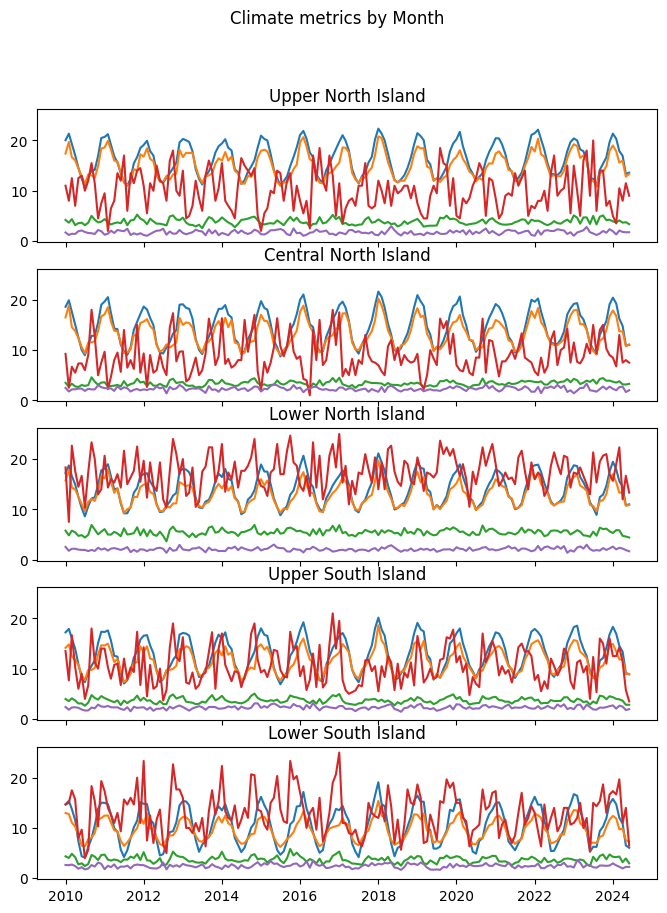

In [14]:
numeric_columns = ['Mean Air Temperature in Celsius', 
                   'Mean Vapour Pressure Hpa', 
                   'Mean Wind Speed M/Sec', 
                   'Days Of Wind Gust >= 24 Knots in Day', 
                   'Standard Deviation Of Daily Mean Temperature in Celsius']

months = uni_climate_electricity['Date'].values.reshape(-1, 1)

fig, axs = plt.subplots(5, sharex= True, sharey=True, figsize=(8, 10))
fig.suptitle('Climate metrics by Month')

axs[0].plot(months, uni_climate_electricity[numeric_columns].values)
axs[0].set_title('Upper North Island')


axs[1].plot(months, cni_climate_electricity[numeric_columns].values)
axs[1].set_title('Central North Island')

axs[2].plot(months, lni_climate_electricity[numeric_columns].values)
axs[2].set_title('Lower North Island')

axs[3].plot(months, usi_climate_electricity[numeric_columns].values)
axs[3].set_title('Upper South Island')

axs[4].plot(months, lsi_climate_electricity[numeric_columns].values)
axs[4].set_title('Lower South Island')

Text(0.5, 1.0, 'Lower South Island')

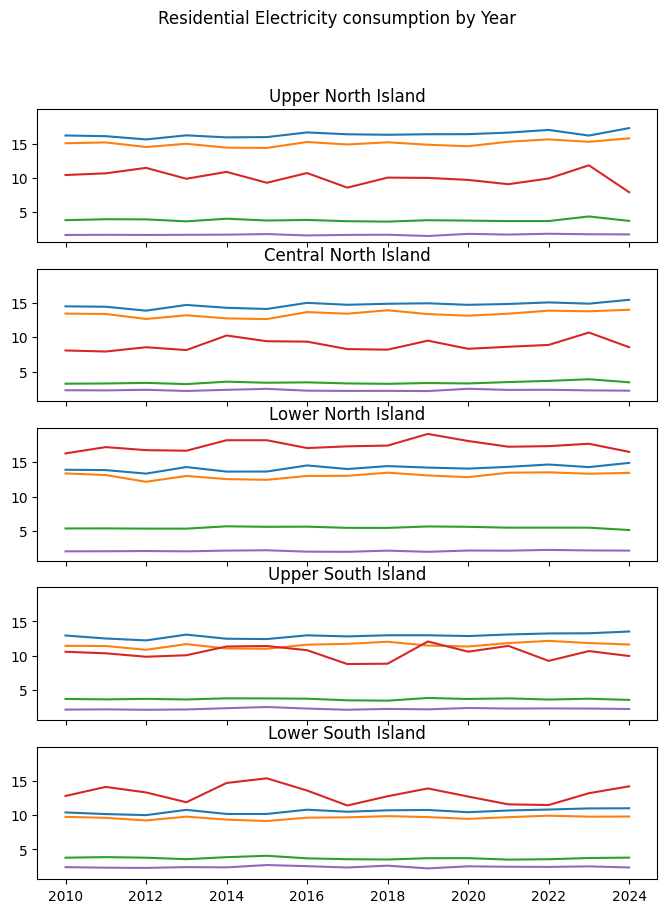

In [15]:

numeric_columns = ['Mean Air Temperature in Celsius', 
                   'Mean Vapour Pressure Hpa', 
                   'Mean Wind Speed M/Sec', 
                   'Days Of Wind Gust >= 24 Knots in Day', 
                   'Standard Deviation Of Daily Mean Temperature in Celsius']

years = uni_byyear['Year'].values.reshape(-1, 1)

fig, axs = plt.subplots(5, sharex= True, sharey=True, figsize=(8, 10))
fig.suptitle('Residential Electricity consumption by Year')

axs[0].plot(years, uni_byyear[numeric_columns].values)
axs[0].set_title('Upper North Island')


axs[1].plot(years, cni_byyear[numeric_columns].values)
axs[1].set_title('Central North Island')

axs[2].plot(years, lni_byyear[numeric_columns].values)
axs[2].set_title('Lower North Island')

axs[3].plot(years, usi_byyear[numeric_columns].values)
axs[3].set_title('Upper South Island')

axs[4].plot(years, lsi_byyear[numeric_columns].values)
axs[4].set_title('Lower South Island')




Text(0.5, 1.0, 'Lower South Island')

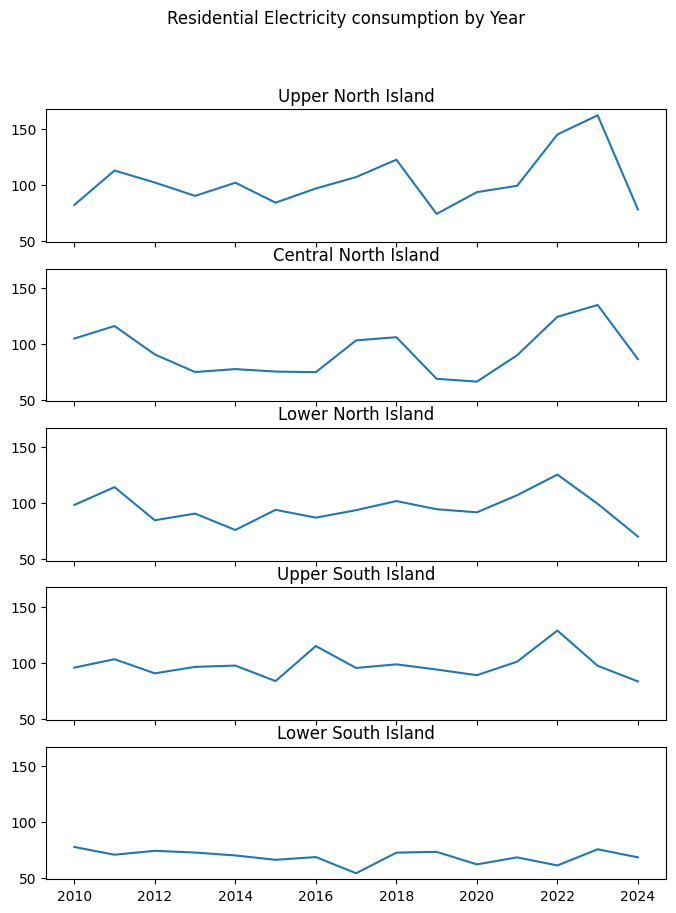

In [57]:
numeric_columns = ['Total Rainfall Mm']

fig, axs = plt.subplots(5, sharex= True, sharey=True, figsize=(8, 10))
fig.suptitle('Residential Electricity consumption by Year')

axs[0].plot(years, uni_byyear[numeric_columns].values)
axs[0].set_title('Upper North Island')


axs[1].plot(years, cni_byyear[numeric_columns].values)
axs[1].set_title('Central North Island')

axs[2].plot(years, lni_byyear[numeric_columns].values)
axs[2].set_title('Lower North Island')

axs[3].plot(years, usi_byyear[numeric_columns].values)
axs[3].set_title('Upper South Island')

axs[4].plot(years, lsi_byyear[numeric_columns].values)
axs[4].set_title('Lower South Island')


## Electricity Data

#### Electricity Business Data

Text(0, 0.5, 'Selected business demand (GWh)')

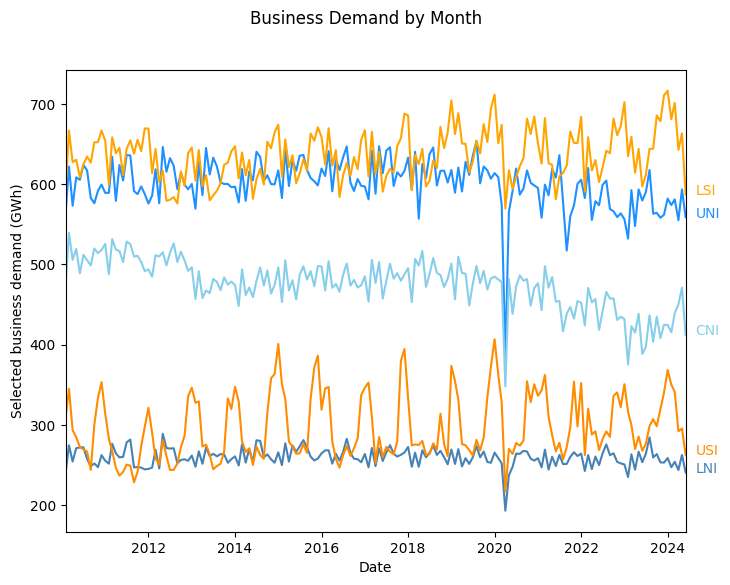

In [16]:
numeric_columns = ['Selected business demand (GWh)']

months = uni_climate_electricity['Date'].values.reshape(-1, 1)

fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle('Business Demand by Month')

month_shift = months[-1] + pd.Timedelta(weeks=12)

label = 'UNI'
color = 'dodgerblue'
axs.plot(months, uni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], uni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, uni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'CNI'
color = 'skyblue'
axs.plot(months, cni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], cni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, cni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'LNI'
color = 'steelblue'
axs.plot(months, lni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], lni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, lni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)

label = 'USI'
color = 'darkorange'
axs.plot(months, usi_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], usi_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, usi_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'LSI'
color = 'orange'
axs.plot(months, lsi_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], lsi_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, lsi_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)

axs.set_xlim(months[1], months[-1])

axs.set_xlabel('Date')
axs.set_ylabel('Selected business demand (GWh)')




Text(0, 0.5, 'Selected business demand (GWh)')

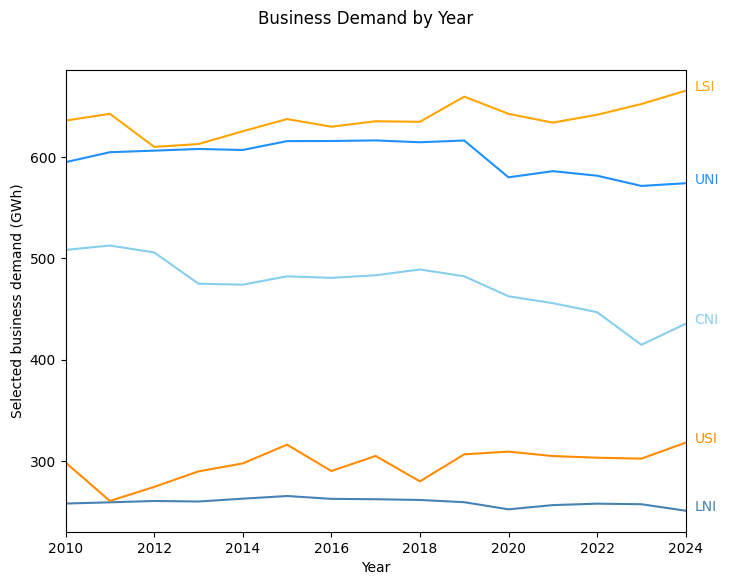

In [18]:
numeric_columns = ['Selected business demand (GWh)']
year_offset = years[-1] + 0.2

fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle('Business Demand by Year')


label = 'UNI'
color = 'dodgerblue'
axs.plot(years, uni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], uni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, uni_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'CNI'
color = 'skyblue'
axs.plot(years, cni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], cni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, cni_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'LNI'
color = 'steelblue'
axs.plot(years, lni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1,], lni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, lni_byyear[numeric_columns].values[-1]),
  color  = color,
)

label = 'USI'
color = 'darkorange'
axs.plot(years, usi_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], usi_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, usi_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'LSI'
color = 'orange'
axs.plot(years, lsi_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], lsi_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, lsi_byyear[numeric_columns].values[-1]),
  color  = color,
)

axs.set_xlim(2010, years[-1])

axs.set_xlabel('Year')
axs.set_ylabel('Selected business demand (GWh)')




#### Electricity Residential Data

Text(0, 0.5, 'Est. Total consumption (GWh)')

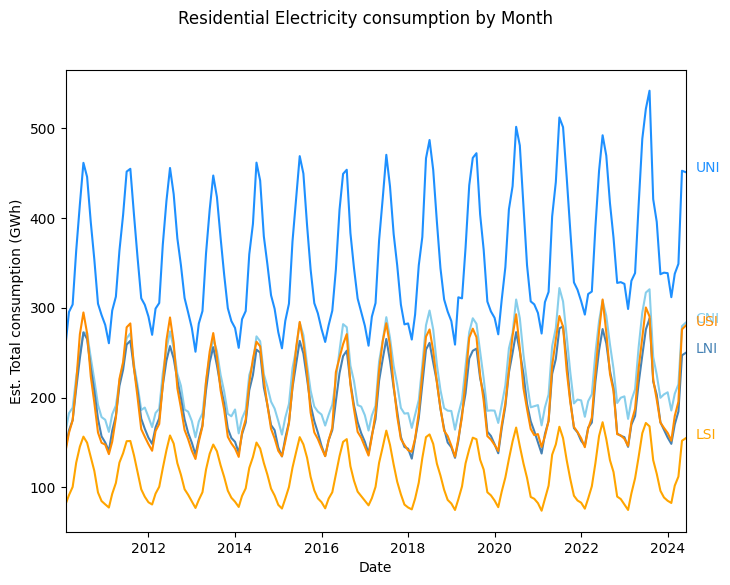

In [19]:
numeric_columns = ['Est. Total consumption (GWh)']
months = uni_climate_electricity['Date'].values.reshape(-1, 1)

fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle('Residential Electricity consumption by Month')

month_shift = months[-1] + pd.Timedelta(weeks=12)

label = 'UNI'
color = 'dodgerblue'
axs.plot(months, uni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], uni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, uni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'CNI'
color = 'skyblue'
axs.plot(months, cni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], cni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, cni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'LNI'
color = 'steelblue'
axs.plot(months, lni_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], lni_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, lni_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)

label = 'USI'
color = 'darkorange'
axs.plot(months, usi_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], usi_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, usi_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)


label = 'LSI'
color = 'orange'
axs.plot(months, lsi_climate_electricity[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (months[-1], lsi_climate_electricity[numeric_columns].values[-1]),
  xytext = (month_shift, lsi_climate_electricity[numeric_columns].values[-1]),
  color  = color,
)

axs.set_xlim(months[1], months[-1])

axs.set_xlabel('Date')
axs.set_ylabel('Est. Total consumption (GWh)')




Text(0, 0.5, 'Est. Total consumption (GWh)')

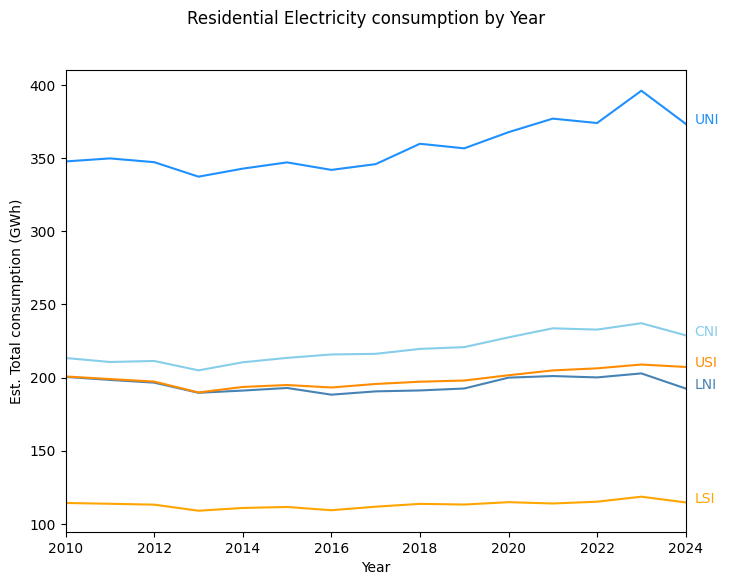

In [20]:
numeric_columns = ['Est. Total consumption (GWh)']

fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle('Residential Electricity consumption by Year')

year_offset = years[-1] + 0.2

label = 'UNI'
color = 'dodgerblue'
axs.plot(years, uni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], uni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, uni_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'CNI'
color = 'skyblue'
axs.plot(years, cni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], cni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, cni_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'LNI'
color = 'steelblue'
axs.plot(years, lni_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1,], lni_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, lni_byyear[numeric_columns].values[-1]),
  color  = color,
)

label = 'USI'
color = 'darkorange'
axs.plot(years, usi_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], usi_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, usi_byyear[numeric_columns].values[-1]),
  color  = color,
)


label = 'LSI'
color = 'orange'
axs.plot(years, lsi_byyear[numeric_columns].values, color=color)
axs.annotate(label,
  xy = (years[-1], lsi_byyear[numeric_columns].values[-1]),
  xytext = (year_offset, lsi_byyear[numeric_columns].values[-1]),
  color  = color,
)

axs.set_xlim(2010, years[-1])

axs.set_xlabel('Year')
axs.set_ylabel('Est. Total consumption (GWh)')




### Correlation visualisation

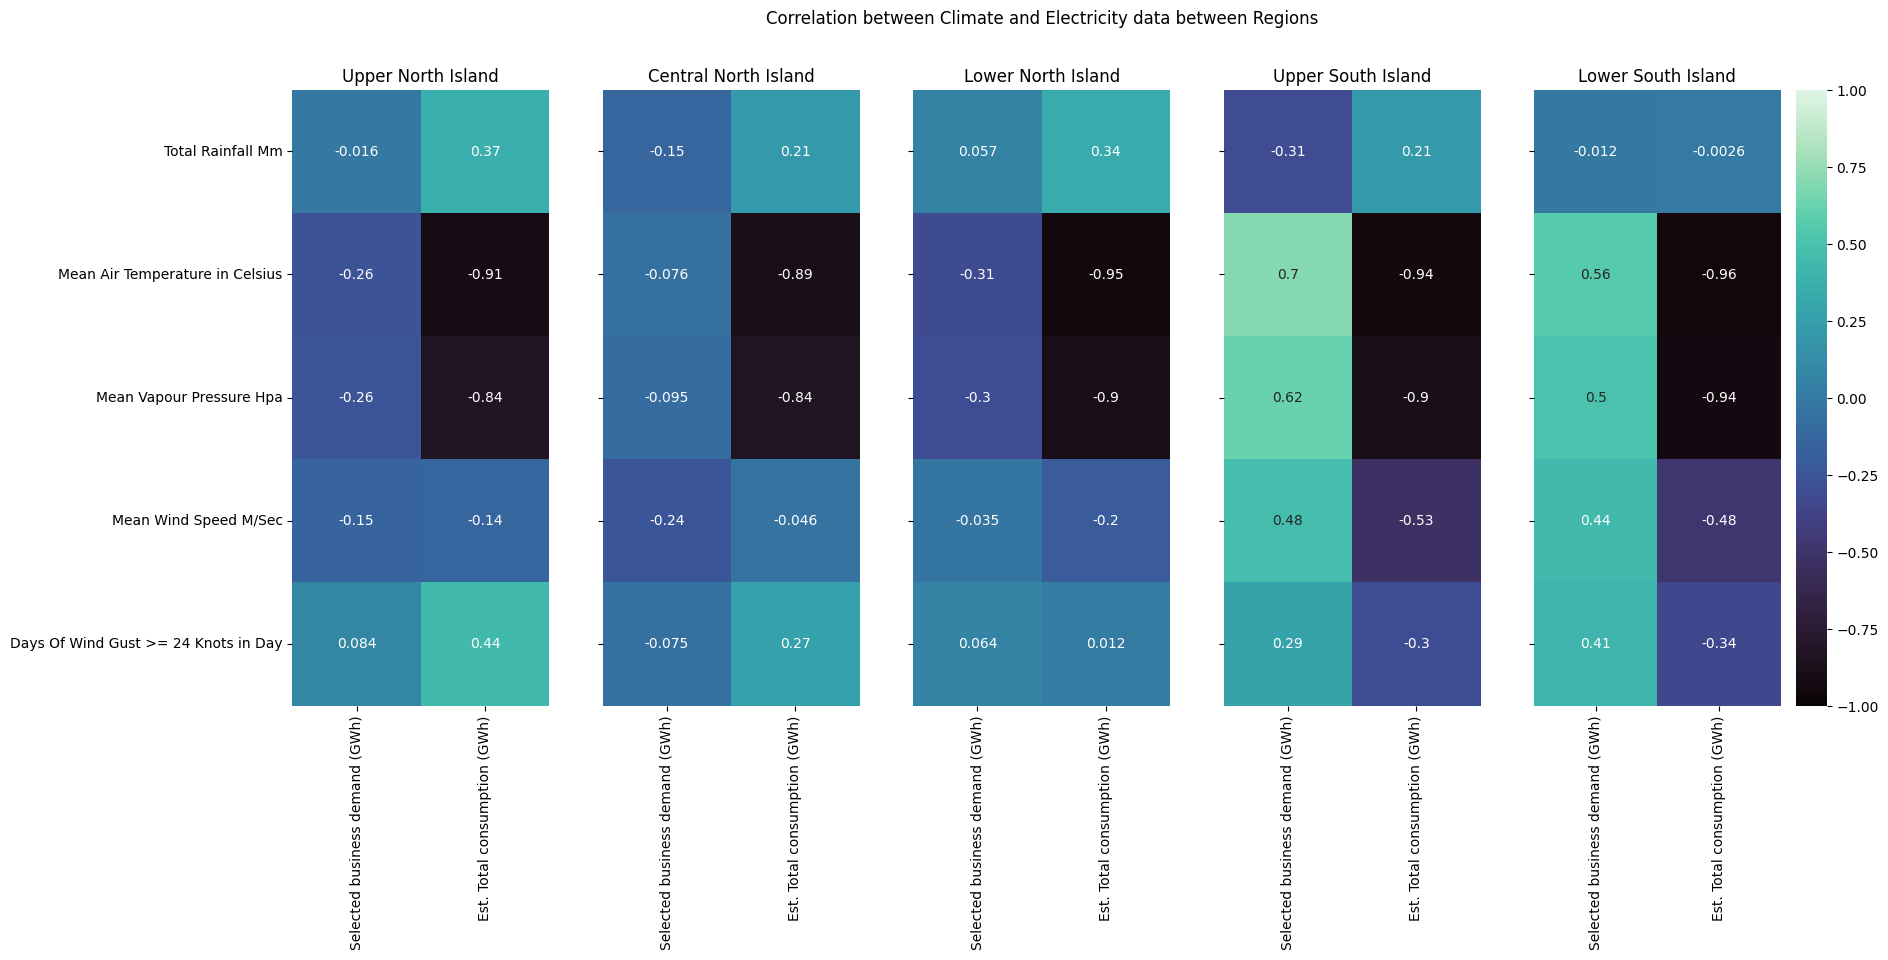

In [35]:

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20, 8), sharey=True, sharex=True, gridspec_kw=dict(width_ratios=[1,1,1,1,1.2]))

fig.suptitle('Correlation between Climate and Electricity data between Regions')

sns.heatmap(uni_climate_electricity.corr().iloc[1:6, 9:11][['Selected business demand (GWh)', 'Est. Total consumption (GWh)']],
      vmin=-1, vmax=1, annot=True, ax=ax1, cbar=False, cmap='mako')
ax1.set_title('Upper North Island')

sns.heatmap(cni_climate_electricity.corr().iloc[1:6, 9:11][['Selected business demand (GWh)', 'Est. Total consumption (GWh)']],
      vmin=-1, vmax=1, annot=True, ax=ax2, cbar=False, cmap='mako')
ax2.set_title('Central North Island')

sns.heatmap(lni_climate_electricity.corr().iloc[1:6, 9:11][['Selected business demand (GWh)', 'Est. Total consumption (GWh)']],
      vmin=-1, vmax=1, annot=True, ax=ax3, cbar=False, cmap='mako')
ax3.set_title('Lower North Island')

sns.heatmap(usi_climate_electricity.corr().iloc[1:6, 9:11][['Selected business demand (GWh)', 'Est. Total consumption (GWh)']],
      vmin=-1, vmax=1, annot=True, ax=ax4, cbar=False, cmap='mako')
ax4.set_title('Upper South Island')

sns.heatmap(lsi_climate_electricity.corr().iloc[1:6, 9:11][['Selected business demand (GWh)', 'Est. Total consumption (GWh)']],
      vmin=-1, vmax=1, annot=True, ax=ax5, cmap='mako')
ax5.set_title('Lower South Island')

plt.show()





<Axes: >

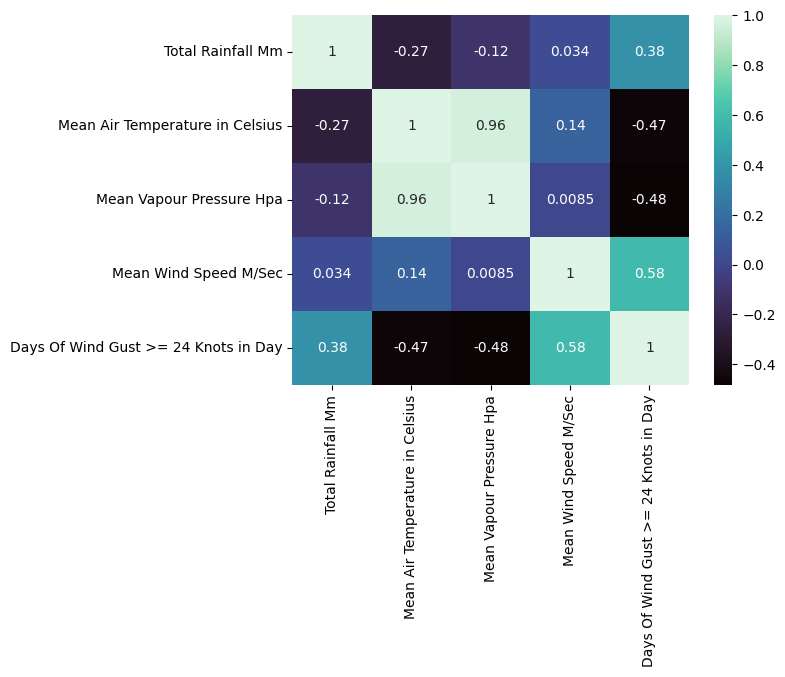

In [36]:
sns.heatmap(uni_climate_electricity.corr().iloc[1:6, 1:6], annot=True, cmap='mako')

### Feature Selection Checking

In [19]:
def lasso_feature_selection(X, y, alpha):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    index = [i for i, coef in enumerate(lasso.coef_) if coef != 0]
    return lasso.coef_, X.columns[index]

In [20]:
def mi_feature_selection(X, y):
    mi = mutual_info_regression(X, y)
    return pd.DataFrame({'Feature': X.columns, 'MI Score': mi}).sort_values(by='MI Score', ascending=False)

In [21]:
def rfe_feature_selection(X, y, n_features):
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=n_features)
    selector = selector.fit(X, y)
    return selector.support_, X.columns[selector.support_]

In [22]:
x = merged_data[['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius']]

yr = merged_data['Est. Total consumption (GWh)']
yb = merged_data['Selected business demand (GWh)']




In [23]:
coef, names = lasso_feature_selection(x, yr, 0.1)
print('Est. Total consumption (GWh)')
print('Coefficients:', coef.round(2))
print('Selected Features:', names)
print('----------------------------------------')

coef, names = lasso_feature_selection(x, yb, 0.1)
print('Selected business demand (GWh)')
print('Coefficients:', coef.round(2))
print('Selected Features:', names)
print('----------------------------------------')



Est. Total consumption (GWh)
Coefficients: [ -0.04 -18.89  11.    20.5   -0.65  -2.06]
Selected Features: Index(['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius'],
      dtype='object')
----------------------------------------
Selected business demand (GWh)
Coefficients: [-1.000e-02  8.980e+00 -1.103e+01 -4.424e+01  3.210e+00  0.000e+00]
Selected Features: Index(['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day'],
      dtype='object')
----------------------------------------


In [24]:
mi = mi_feature_selection(x, yr)
print('Est. Total consumption (GWh)')
print(mi)
print('----------------------------------------')

mi = mi_feature_selection(x, yb)
print('Selected business demand (GWh)')
print(mi)
print('----------------------------------------')


Est. Total consumption (GWh)
                                             Feature  MI Score
1                    Mean Air Temperature in Celsius  0.901969
2                           Mean Vapour Pressure Hpa  0.659550
4               Days Of Wind Gust >= 24 Knots in Day  0.195662
0                                  Total Rainfall Mm  0.098973
3                              Mean Wind Speed M/Sec  0.043359
5  Standard Deviation Of Daily Mean Temperature i...  0.000000
----------------------------------------
Selected business demand (GWh)
                                             Feature  MI Score
1                    Mean Air Temperature in Celsius  0.060432
0                                  Total Rainfall Mm  0.046328
5  Standard Deviation Of Daily Mean Temperature i...  0.029152
3                              Mean Wind Speed M/Sec  0.010605
2                           Mean Vapour Pressure Hpa  0.000000
4               Days Of Wind Gust >= 24 Knots in Day  0.000000
-----------------

In [25]:

support, names = rfe_feature_selection(x, yr, 3)
print('Est. Total consumption (GWh)')
print('Selected Features:', names)
print('----------------------------------------')

support, names = rfe_feature_selection(x, yb, 3)
print('Selected business demand (GWh)')
print('Selected Features:', names)
print('----------------------------------------')

Est. Total consumption (GWh)
Selected Features: Index(['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa',
       'Mean Wind Speed M/Sec'],
      dtype='object')
----------------------------------------
Selected business demand (GWh)
Selected Features: Index(['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa',
       'Mean Wind Speed M/Sec'],
      dtype='object')
----------------------------------------


### Transformations

In [26]:
merged_data.columns

Index(['Date', 'Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius', 'Year',
       'Month', 'Selected business demand (GWh)',
       'Est. Total consumption (GWh)'],
      dtype='object')

In [27]:
def normalise_df(df):
    scaler = MinMaxScaler()
    no_date = df.drop(columns='Date')
    df_normalised = pd.DataFrame(scaler.fit_transform(no_date), columns=no_date.columns)
    df_normalised['Date'] = df['Date']
    return df_normalised

In [28]:
normalised_data = normalise_df(merged_data)

In [29]:
normalised_data.head()

,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Date
0,0.717349,0.772983,0.672489,0.505747,0.485294,0.558442,0.0,0.000000,0.809705,0.127939,2010-01-01
1,0.051852,0.870544,0.879913,0.137931,0.088235,0.181818,0.0,0.090909,0.668736,0.042331,2010-02-01
2,0.035446,0.697936,0.524017,0.306513,0.333333,0.346320,0.0,0.181818,1.000000,0.161039,2010-03-01
3,0.193788,0.508443,0.436681,0.172414,0.264706,0.415584,0.0,0.272727,0.825026,0.198098,2010-04-01
4,0.835324,0.317699,0.331878,0.076628,0.372549,0.484848,0.0,0.363636,0.895735,0.402618,2010-05-01


### Save dataframe

In [30]:
normalised_data.to_csv(f'WeatherBusinessResidentialMinMax.csv', index=False) 